In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from __future__ import division
from deltasigma import *
import numpy as np

In [3]:
fig_number = 0
base_name = 'dsdemo2'
def save_fig(fig_number):
    save_name = f'{base_name}_fig{fig_number:02d}.pdf'
    fig_number = fig_number + 1
    plt.gcf().savefig(save_name)
    return fig_number

NTF synthesis - demo #2
=======================

Demonstration of the **`simulateDSM`** function, as in the **MATLAB Delta Sigma Toolbox**, employing its Python port **`deltasigma`**.

 * In the first section, the **Noise Transfer Function** (NTF) is synthesized for a **5th-order**, **low-pass** modulator and 
   for a **8th-order band-pass** modulator.  
     * In each case, the modulator is **simulated** - with `simulateDSM` - and its output plotted in terms of **time response**
       and **spectrum**.
     * The **Signal to Noise Ratio** (SNR) is evaluated from the spectrum through `calculateSNR`.
     * The **SNR** for different amplitudes is **predicted** through `predictSNR`, **simulated** with `simulateSNR` and 
       the **peak values are extracted** with `peakSNR`.

 * In the second section we move on to the synthesis and simulation of a **7th-order low-pass multi-bit modulator**.

5th-order low-pass modulator
----------------------------

General parameters and synthesis:

In [4]:
OSR = 32
order = 5
H = synthesizeNTF(order, OSR, 1)

### Time-domain simulation with `simulateDSM`

A test sine wave is employed for the time simulation, having amplitude $A = .5$ (equiv. -6 dBFS) and a frequency equal to $f_{test} = 2/3 f_B$.

C:\Users\hansp\Desktop\42\SVN\python-deltasigma\deltasigma\_simulateDSM.py:216: UserWarning: Using a slow implementation of simulateDSM
Refer to the docs for how to switch to a fast one
  warn('Using a slow implementation of simulateDSM\n' +


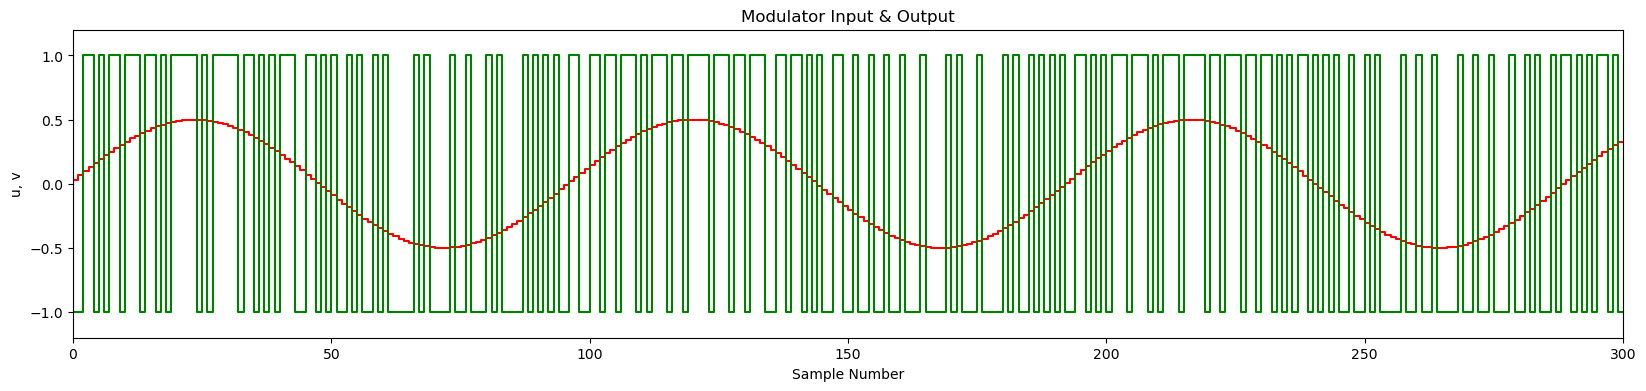

In [5]:
plt.figure(figsize=(20, 4))
N = 8192
fB = int(np.ceil(N/(2.*OSR)))
ftest = np.floor(2./3.*fB)
u = 0.5*np.sin(2*np.pi*ftest/N*np.arange(N))
v, xn, xmax, y = simulateDSM(u, H)
t = np.arange(301)
plt.step(t, u[t],'r')
plt.step(t, v[t], 'g')
plt.axis([0, 300, -1.2, 1.2])
plt.xlabel('Sample Number')
plt.ylabel('u, v')
plt.title('Modulator Input & Output');
fig_number = save_fig(fig_number)

### Output spectrum and extraction of the SNR with `calculateSNR`

From the above time simulation, the spectrum is computed - through direct FFT of the Hann-windowed time waveform. 

The obtained spectrum (*blue*) is compared with the expected performances that can be computed evaluating the modulator transfer function in the frequency domain (*magenta*).

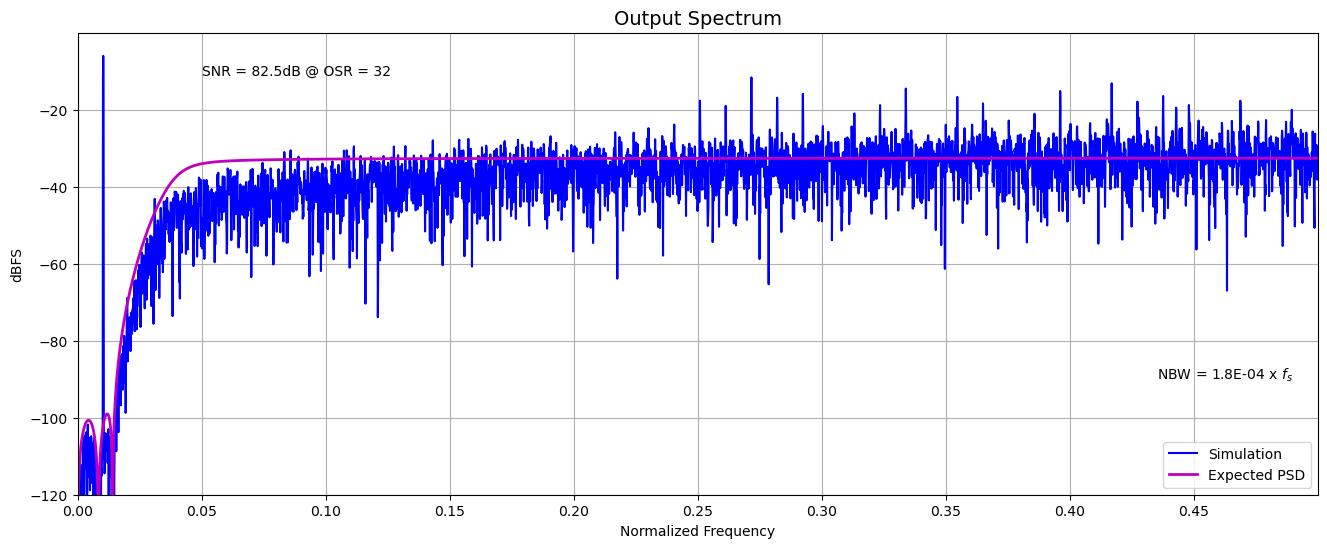

In [6]:
f = np.linspace(0, 0.5, N//2 + 1)
spec = np.fft.fft(v * ds_hann(N))/(N/4)
plt.plot(f, dbv(spec[:N//2 + 1]),'b', label='Simulation')
figureMagic([0, 0.5], 0.05, None, [-120, 0], 20, None, (16, 6), 'Output Spectrum')
plt.xlabel('Normalized Frequency')
plt.ylabel('dBFS')
snr = calculateSNR(spec[2:fB+1], ftest - 2)
plt.text(0.05, -10, 'SNR = %4.1fdB @ OSR = %d' % (snr, OSR), verticalalignment='center')
NBW = 1.5/N
Sqq = 4*evalTF(H, np.exp(2j*np.pi*f)) ** 2/3.
plt.plot(f, dbp(Sqq * NBW), 'm', linewidth=2, label='Expected PSD')
plt.text(0.49, -90, 'NBW = %4.1E x $f_s$' % NBW, horizontalalignment='right')
plt.legend(loc=4);
fig_number = save_fig(fig_number)

### SNR vs input amplitude: prediction, simulation and peak extraction

Being the example modulator a binary (single-bit) structure, we can predict the SNR curve using *the describing function method of Ardalan and Paulos*. This is done with the function `predictSNR`.

Next, we check the agreement between the approximate - but very quick - method above and actual results obtained with extended time simulations of the modulator. This operation is performed by `simulateSNR`.

Lastly, we interpolate the simulation results close to the SNR peak, with `peakSNR`, to get an approximate value for peak SNR that can be ideally expected by the syntesized modulator structure and its corresponding amplitude value.

In [7]:
snr_pred, amp_pred, _, _, _ = predictSNR(H, OSR)
snr, amp  = simulateSNR(H, OSR)

C:\Users\hansp\miniconda3\envs\HTU25\Lib\site-packages\scipy\signal\_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)


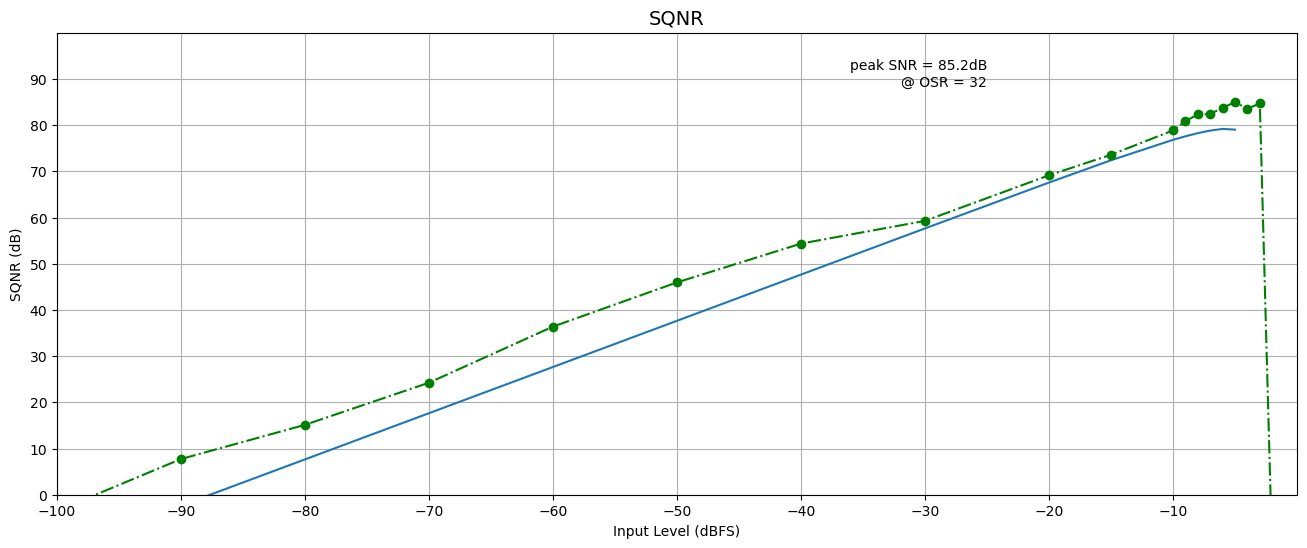

In [8]:
plt.plot(amp_pred, snr_pred, '-', amp, snr, 'og-.')
figureMagic([-100, 0], 10, None, [0, 100], 10, None, (16, 6),'SQNR')
plt.xlabel('Input Level (dBFS)')
plt.ylabel('SQNR (dB)')
pk_snr, pk_amp = peakSNR(snr, amp)
plt.text(-25, 85, 'peak SNR = %4.1fdB\n@ OSR = %d\n' % (pk_snr[0][0], OSR), horizontalalignment='right');
fig_number = save_fig(fig_number)

### Bandpass Modulator

In [9]:
f0 = 1./8
OSR = 64
order = 8
H = synthesizeNTF(order, OSR, 1, 1.5, f0)

### Time-domain simulation with `simulateDSM`

A test sine wave is employed for the time simulation, having amplitude $A = .5$ (equiv. -6 dBFS) and a frequency offset from $f_0$ equal to $\Delta f_{test} = 1/3 f_B$.

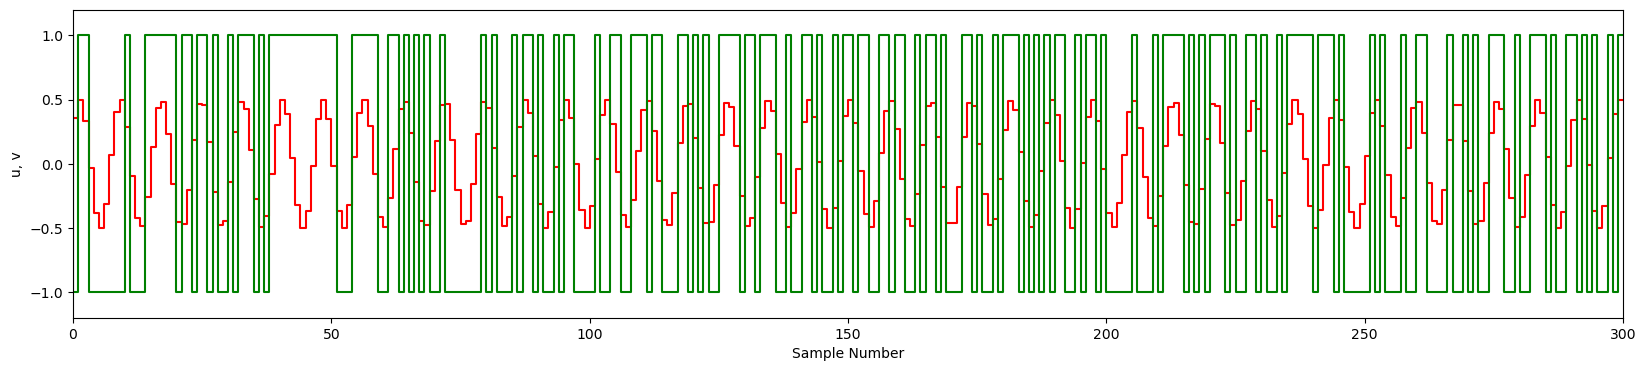

In [10]:
plt.figure(figsize=(20, 4))
fB = int(np.ceil(N/(2. * OSR)))
ftest = int(np.round(f0*N + 1./3 * fB))
u = 0.5*np.sin(2*np.pi*ftest/N*np.arange(N))
v, xn, xmax, y = simulateDSM(u, H)
t = np.arange(301)
plt.step(t, u[t], 'r')
plt.step(t, v[t], 'g')
plt.axis([0, 300, -1.2, 1.2])
plt.xlabel('Sample Number')
plt.ylabel('u, v')
fig_number = save_fig(fig_number)

### Output spectrum and extraction of the SNR with `calculateSNR`

As in the case before, from the above time simulation, the spectrum is computed - through direct FFT of the Hann-windowed time waveform. 

The obtained spectrum (*blue*) is compared with the expected performances that can be computed evaluating the modulator transfer function in the frequency domain (*magenta*).

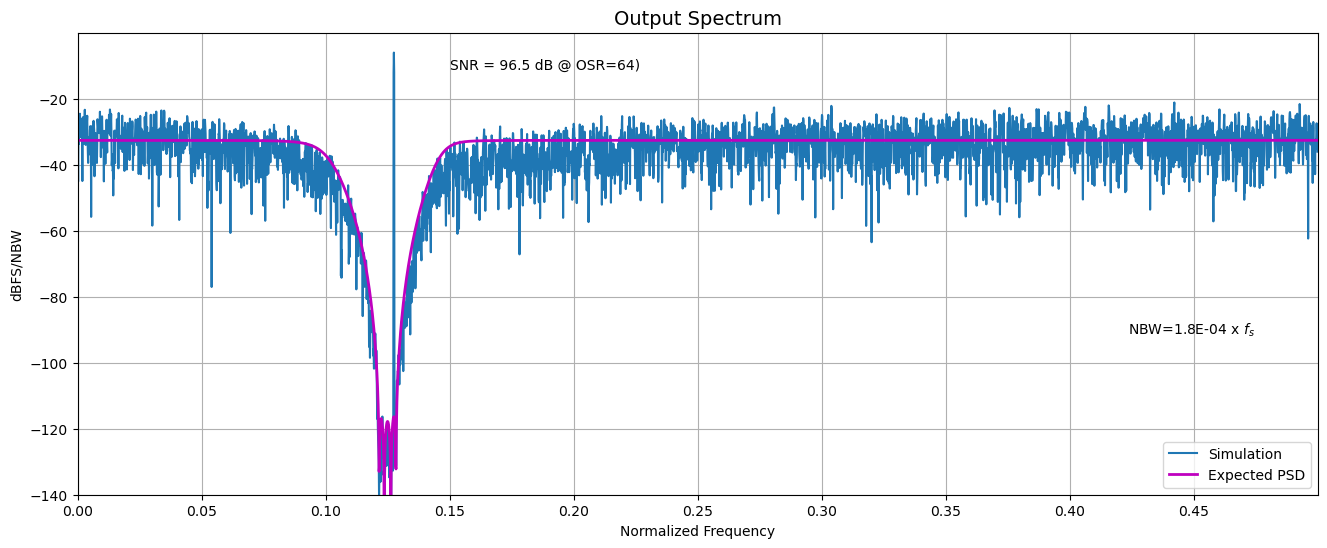

In [11]:
spec = np.fft.fft(v*ds_hann(N))/(N/4)
plt.plot(np.linspace(0, 0.5, N//2 + 1), dbv(spec[:N//2 + 1]), label='Simulation')
figureMagic([0, 0.5], 0.05, None, [-140, 0], 20, None, (16, 6), 'Output Spectrum')
f1 = int(np.round((f0 - 0.25/OSR) * N))
f2 = int(np.round((f0 + 0.25/OSR) * N))
snr = calculateSNR(spec[f1:f2+1], ftest - f1)
plt.text(0.15, -10, 'SNR = %4.1f dB @ OSR=%d)' % (snr, OSR), verticalalignment='center')
plt.grid(True)
plt.xlabel('Normalized Frequency')
plt.ylabel('dBFS/NBW')
NBW = 1.5/N
Sqq = 4*evalTF(H, np.exp(2j*np.pi*f))**2/3.
plt.plot(f, dbp(Sqq*NBW), 'm', linewidth=2, label='Expected PSD')
plt.text(0.475, -90, 'NBW=%4.1E x $f_s$' % NBW, horizontalalignment='right', verticalalignment='center')
plt.legend(loc=4);
fig_number = save_fig(fig_number)

### SNR vs input amplitude: prediction, simulation and peak extraction

*In the following, the same comments as in the preceeding sections apply, adapted for band-pass frequency charactersistics.*

In [12]:
snr_pred, amp_pred, _, _, _ = predictSNR(H, OSR, None, f0)
snr, amp = simulateSNR(H, OSR, None, f0)

C:\Users\hansp\miniconda3\envs\HTU25\Lib\site-packages\scipy\signal\_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)


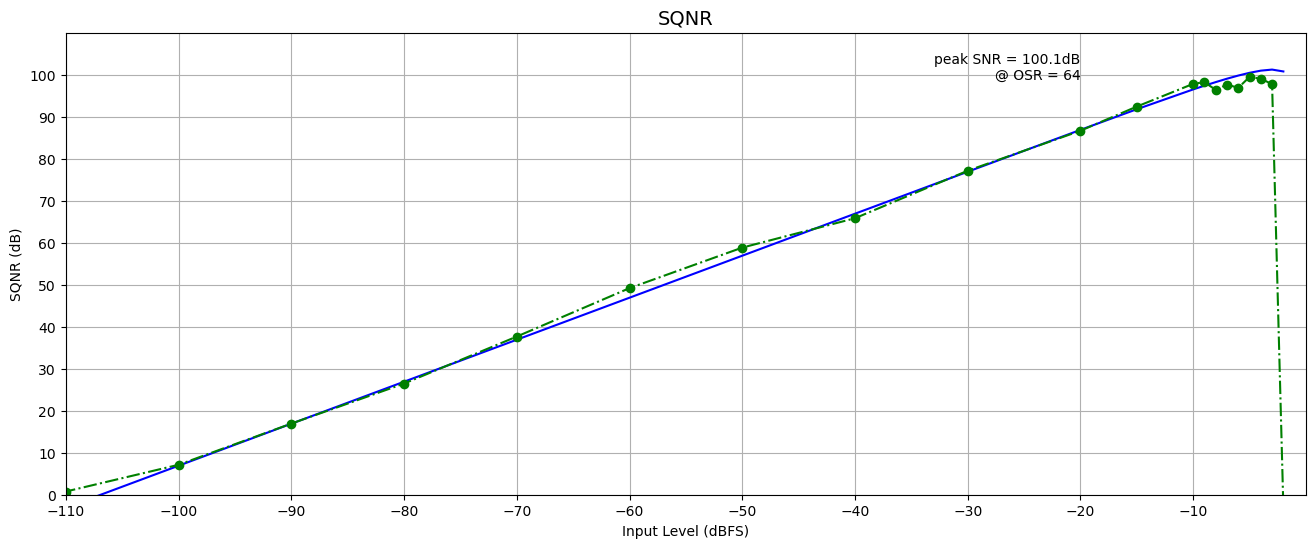

In [13]:
plt.plot(amp_pred, snr_pred, '-b', amp, snr, 'og-.')
figureMagic([-110, 0], 10, None, [0, 110], 10, None, (16, 6), 'SQNR')
plt.xlabel('Input Level (dBFS)')
plt.ylabel('SQNR (dB)')
pk_snr, pk_amp = peakSNR(snr, amp)
plt.text(-20, 95, 'peak SNR = %4.1fdB\n@ OSR = %d\n' % (pk_snr[0][0], OSR), horizontalalignment='right');
fig_number = save_fig(fig_number)

## 7th-order low-pass multi-bit modulator

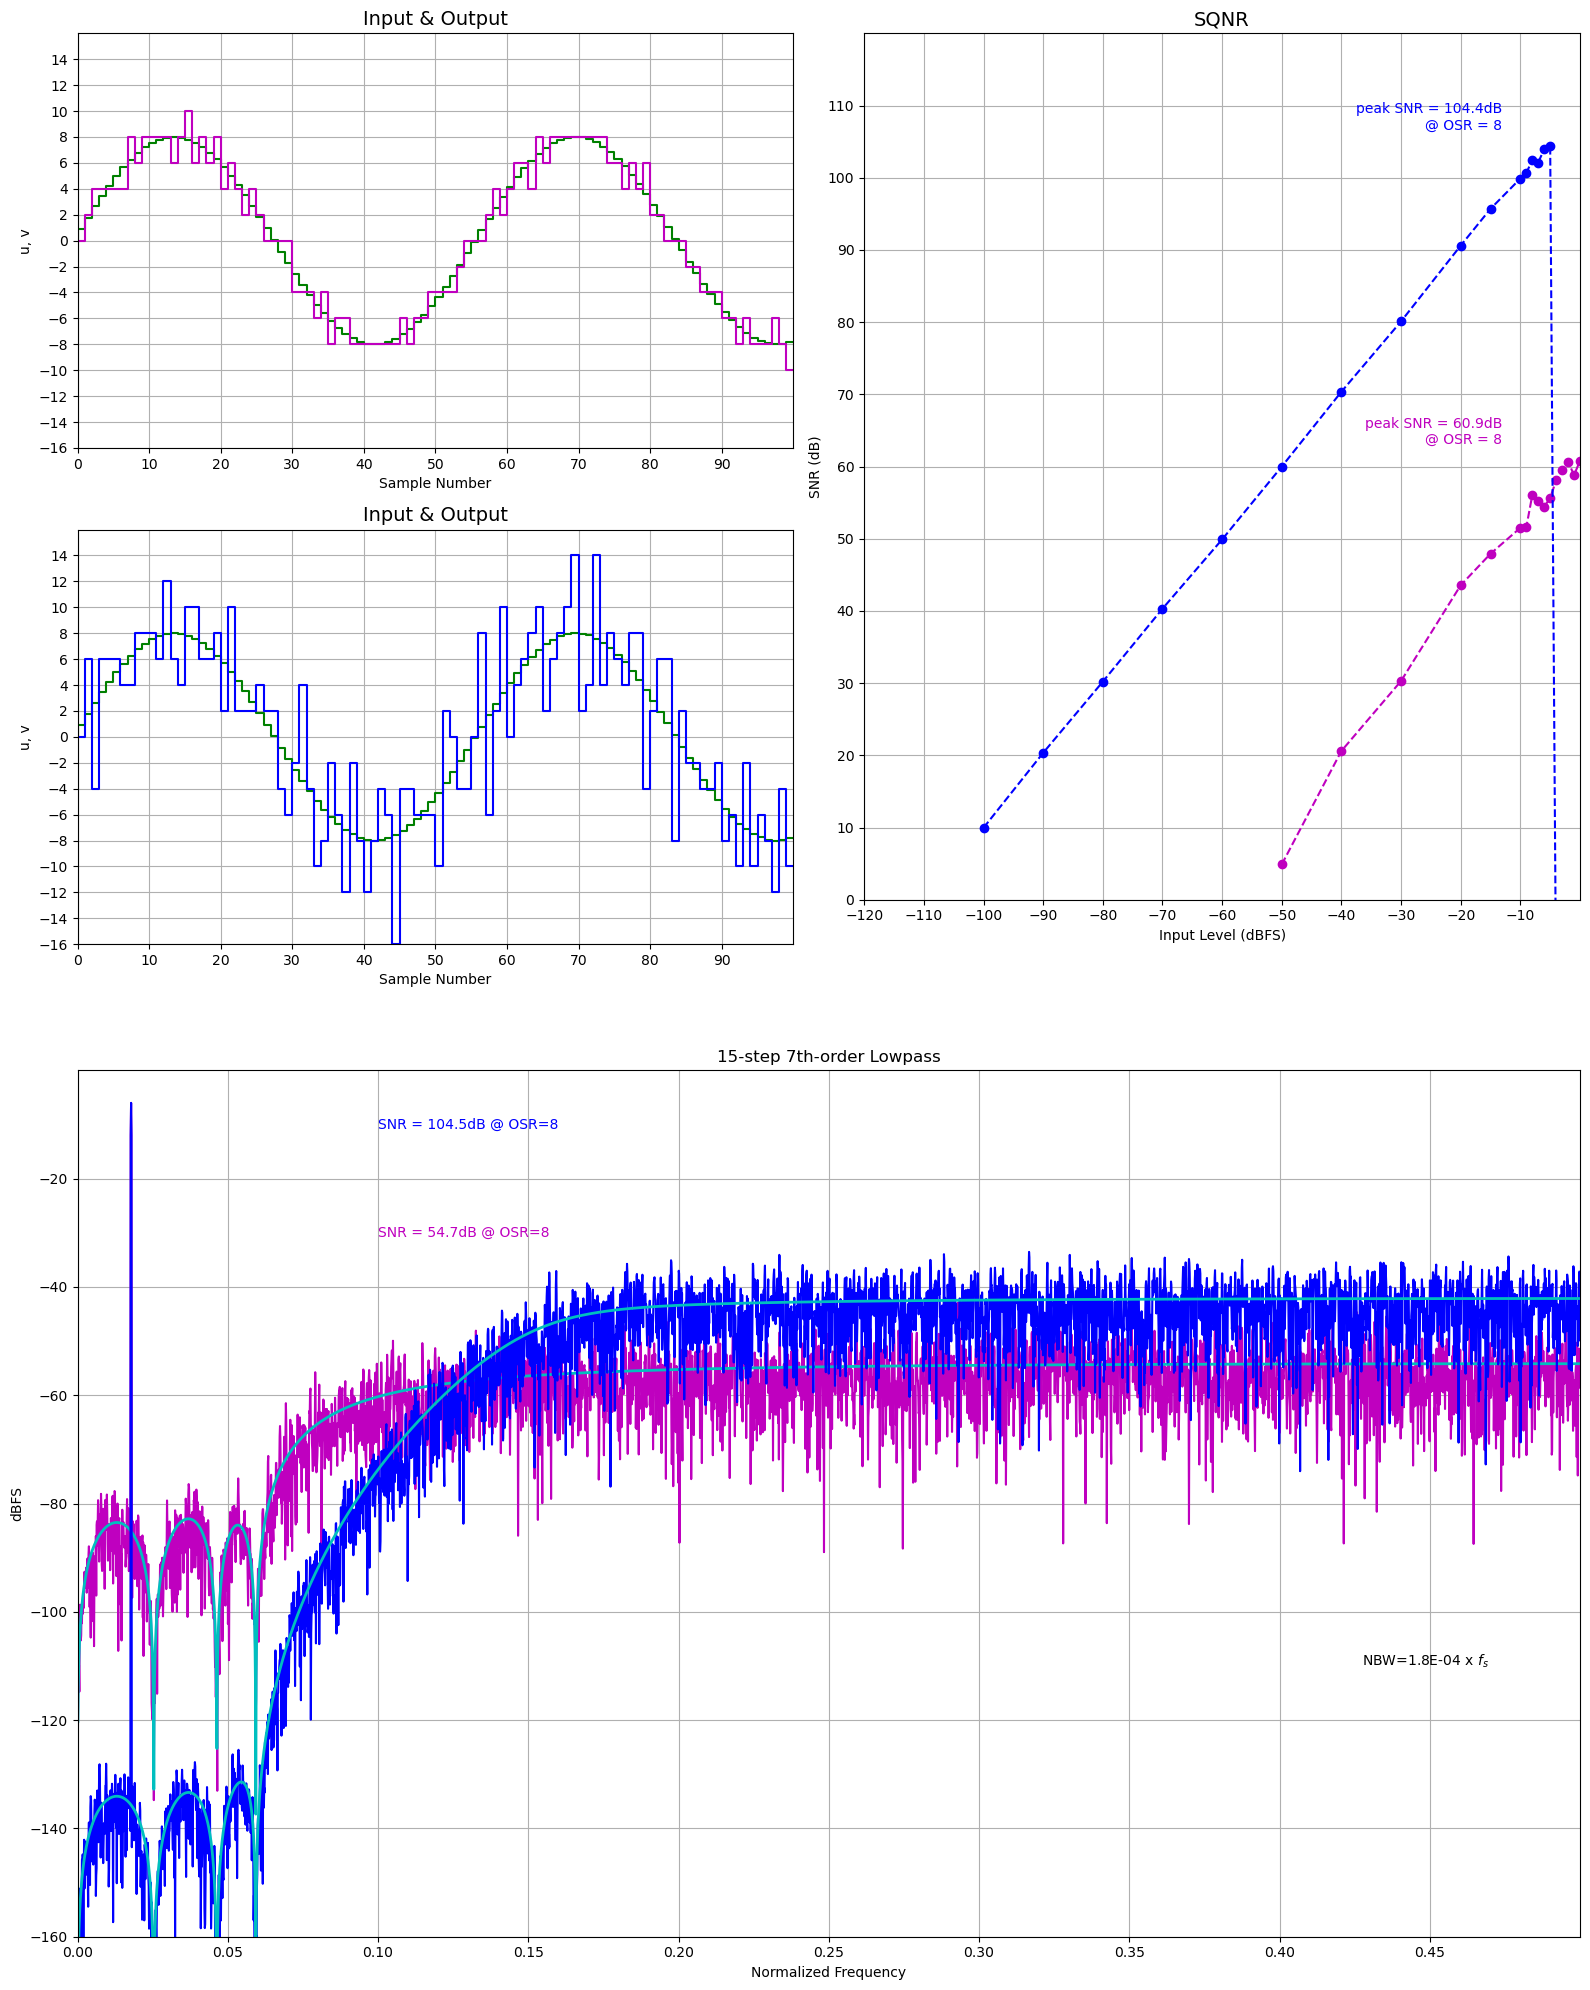

In [14]:
plt.figure(figsize=(16, 20))
colors = ('m', 'b')
Hinf_list = [2, 8]
i = -1
for col, Hinf in zip(colors, Hinf_list):
    i += 2
    OSR = 8
    M = 16
    H = synthesizeNTF(7, OSR, 1, Hinf)
    N = 8192
    fB = int(np.ceil(N/(2.*OSR)))
    ftest = int(np.floor(2./7*fB))
    u = 0.5*M*np.sin(2*np.pi*ftest/N*np.arange(N))
    v, xn, xmax, y = simulateDSM(u, H, M + 1)
    
    plt.subplot(int('42' + str(i)))
    t = np.arange(101)
    plt.step(t, u[t], 'g')
    plt.step(t, v[t], col)
    figureMagic([0, 100], 10, None, [-M, M], 2, None, None,'Input & Output')
    plt.xlabel('Sample Number')
    plt.ylabel('u, v')
    
    plt.subplot(222)
    snr, amp = simulateSNR(H, OSR, None, 0., M + 1)
    plt.plot(amp, snr,'o' + col, amp, snr, '--' + col)
    figureMagic([-120, 0], 10, None, [0, 120], 10, None, None,'SQNR')
    plt.xlabel('Input Level (dBFS)')
    plt.ylabel('SNR (dB)')
    pk_snr, pk_amp = peakSNR(snr, amp)
    plt.text(-13, pk_snr, 'peak SNR = %4.1fdB\n@ OSR = %d\n' % (pk_snr[0][0], OSR), horizontalalignment='right', color=col)
    
    plt.subplot(212)
    f = np.linspace(0, 0.5, N//2 + 1)
    spec = np.fft.fft(v*ds_hann(N))/(M*N/4)
    plt.plot(f, dbv(spec[:N//2 + 1]), col)
    snr = calculateSNR(spec[2:fB + 1], ftest - 2)
    plt.text(0.1, 10*(i - 4), 'SNR = %4.1fdB @ OSR=%d' % (snr, OSR), verticalalignment='center', color=col)
    figureMagic([0, 0.5], 0.05, None, [-160, 0], 20, None, None,'Output Spectrum')
    plt.xlabel('Normalized Frequency')
    plt.ylabel('dBFS')
    
    NBW = 1.5/N
    Sqq = 4*evalTF(H, np.exp(2j*np.pi*f))**2/(3.*M**2)
    plt.plot(f, dbp(Sqq*NBW), 'c', linewidth=2)
    
    if i == 1:
        plt.text(0.47, -110, 'NBW=%4.1E x $f_s$ '% NBW, horizontalalignment='right')
        
plt.title('15-step 7th-order Lowpass')
plt.tight_layout()
fig_number = save_fig(fig_number)

Further information about simulation of DSM's
---------------------------------------------

Please refer to `help(simulateDSM)` for detailed - and possibly more updated - documentation!

###`help(simulateDSM)` as of writing:

simulateDSM(u, arg2, nlev=2, x0=0)

    [v, xn, xmax, y] = simulateDSM(u, ABCD, nlev=2, x0=0)

or

    [v, xn, xmax, y] = simulateDSM(u, ntf, nlev=2, x0=0)
    
    Compute the output of a general delta-sigma modulator with input ``u``,
    a structure described by ``ABCD``, an initial state ``x0`` (default zero) and
    a quantizer with a number of levels specified by ``nlev``.
    Multiple quantizers are implied by making ``nlev`` an array,
    and multiple inputs are implied by the number of rows in ``u``.
    
    Alternatively, the modulator may be described by an ``NTF``.
    The NTF is a zpk object. (The STF is assumed to be 1.)
    The structure that is simulated is the block-diagional structure used by
    zpk2ss.